In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

np.random.seed(0) 
tf.random.set_seed(0)

### Loading data and preprocessing

In [2]:
df = pd.read_csv('Monthly_oil_data.csv', index_col='Production Date', parse_dates=True)
df['LogVolume'] = np.log(df['Volume']) 
df['DiffLogVolume'] = df['LogVolume'].diff() 
df.head()

,Volume,LogVolume,DiffLogVolume
Production Date,,,
2015-01-01,67515553.0,18.027869,NaN
2015-02-01,61664960.0,17.937226,-0.090642
2015-03-01,66342950.0,18.010348,0.073122
2015-04-01,67719040.0,18.030878,0.020530
2015-05-01,66484591.0,18.012481,-0.018397


### Supervised Dataset

In [3]:
series = df['DiffLogVolume'].to_numpy()[1:] 

T = 12
X = [] 
Y = []  
for t in range(len(series) - T):
    x = series[t:t+T] 
    X.append(x) 
    y = series[t+T] 
    Y.append(y)

X = np.array(X).reshape(-1, T) 
Y = np.array(Y)
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (112, 12) Y.shape (112,)


### Train Test Split

In [4]:
Ntest = 12
train = df.iloc[:-Ntest] 
test = df.iloc[-Ntest:] 

Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest] 
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

### Scaling

In [5]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

Xtrain = scaler_x.fit_transform(Xtrain)
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)

Xtest = scaler_x.transform(Xtest)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

Ytrain = scaler_y.fit_transform(Ytrain.reshape(-1, 1))
Ytest = scaler_y.transform(Ytest.reshape(-1, 1))

### Indexing

In [6]:
train_idx = df.index <= train.index[-1] 
test_idx = ~train_idx 

### RNN

In [7]:
model = Sequential([
    Input(shape=(T, 1)),
    LSTM(40, activation='tanh', return_sequences=True),
    Dropout(0.1),
    LSTM(40, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 40)              │           6,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 40)                  │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,721 (77.04 KB)

 Trainable params: 19,721 (77.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse'
)

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [11]:
r = model.fit(
    Xtrain, 
    Ytrain,
    epochs=100,
    batch_size=16,
    validation_data=(Xtest, Ytest),
    verbose=1,
    shuffle=False
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.2724 - val_loss: 0.2269
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2427 - val_loss: 0.2040
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2239 - val_loss: 0.1828
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1989 - val_loss: 0.1631
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1808 - val_loss: 0.1446
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1609 - val_loss: 0.1272
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1452 - val_loss: 0.1106
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1254 - val_loss: 0.0949
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1106 - val_loss: 0.0801
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0912 - val_loss: 0.0663
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0781 - val_loss: 0.0540
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0666 - val_l

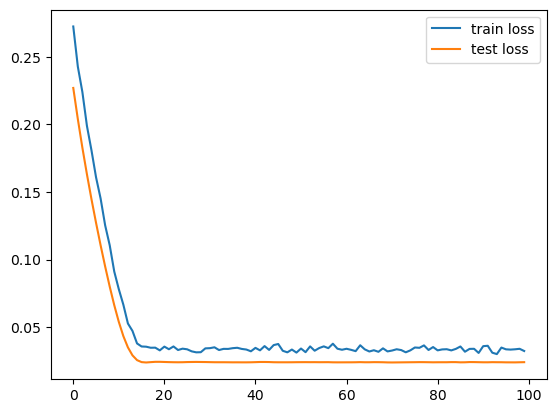

In [12]:
plt.plot(r.history['loss'], label='train loss') 
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

### Make Predictions

In [13]:
train_idx[:T+1] = False # first T+1 values are not predictable

Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

print(Ptrain.shape, Ptest.shape)

Ptrain = scaler_y.inverse_transform(Ptrain.reshape(-1, 1)).flatten()
Ptest = scaler_y.inverse_transform(Ptest.reshape(-1, 1)).flatten()

# needed to compute un-differenced predictions 
df['ShiftLogVolume'] = df['LogVolume'].shift(1) 
prev = df['ShiftLogVolume']

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
(100,) (12,)


### 1-step forecast

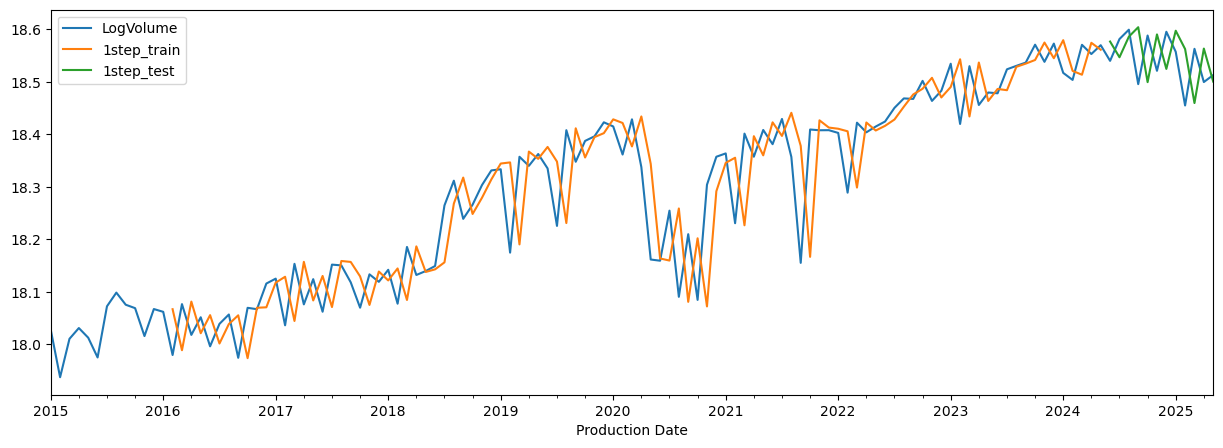

In [14]:
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain 
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest 

# plot 1-step forecast
df[['LogVolume', '1step_train', '1step_test']].plot(figsize=(15,5));

### Multi-step forecast

In [15]:
multistep_predictions = [] 

# first test input
last_x = Xtest[0] 

while len(multistep_predictions) < Ntest: 
    p = model.predict(last_x[np.newaxis, :, :], verbose=0)  # Add verbose=0 to reduce output
    p_value = p[0, 0]
    # update predictions list 
    multistep_predictions.append(p_value) 
    # make the new input 
    last_x = np.roll(last_x, -1) 
    last_x[-1] = p_value

multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler_y.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten() 
# last-known train value 
last_train = train.iloc[-1]['LogVolume']

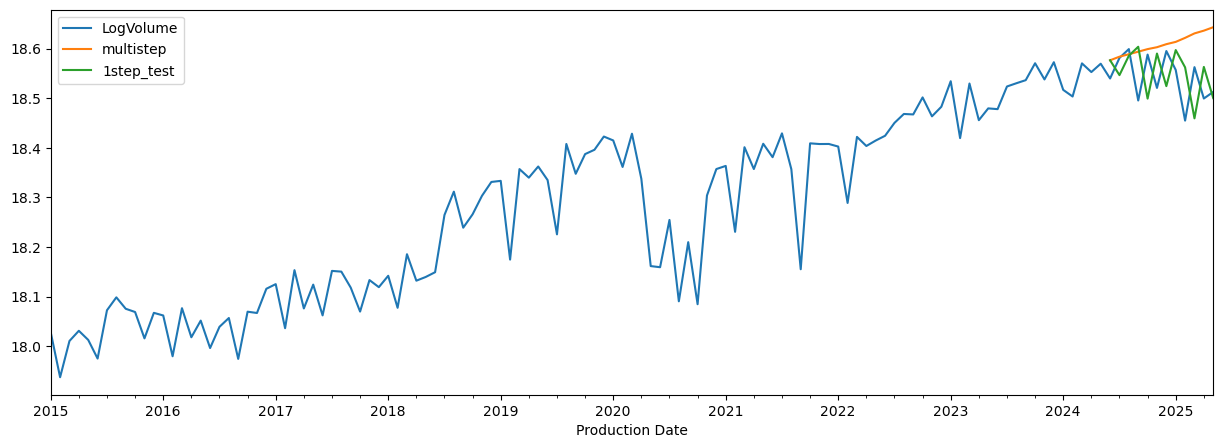

In [16]:
# multi-step forecast 
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions) 

df[['LogVolume', 'multistep', '1step_test']].plot(figsize=(15,5));

### Multi-output supervised dataset

In [17]:
Tx = T 
Ty = Ntest 
X = [] 
Y = [] 

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx) 
Y = np.array(Y).reshape(-1, Ty) 
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (101, 12) Y.shape (101, 12)


### Train/Test Split

In [18]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1] 
Xtest_m, Ytest_m = X[-1:], Y[-1:]

### Scaling

In [19]:
scaler_xm = MinMaxScaler(feature_range=(0, 1))
scaler_ym = MinMaxScaler(feature_range=(0, 1))

Xtrain_m = scaler_xm.fit_transform(Xtrain_m)
Xtrain_m = Xtrain_m.reshape(-1, Xtrain_m.shape[1], 1)

Xtest_m = scaler_xm.transform(Xtest_m)
Xtest_m = Xtest_m.reshape(-1, Xtest_m.shape[1], 1)

Ytrain_m = scaler_ym.fit_transform(Ytrain_m)
Ytest_m = scaler_ym.transform(Ytest_m)

### RNN

In [20]:
model = Sequential([
    Input(shape=(T, 1)),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.1),
    LSTM(128, activation='tanh'),
    Dropout(0.1),
    Dense(Ty)
])

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse'
)

In [22]:
r = model.fit(
    Xtrain_m, 
    Ytrain_m,
    epochs=100,
    batch_size=16,
    validation_data=(Xtest_m, Ytest_m),
    #callbacks=[check_point],
    verbose=1,
    shuffle=False
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.3641 - val_loss: 0.1198
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0794 - val_loss: 0.0352
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0426 - val_loss: 0.0290
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0382 - val_loss: 0.0273
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0354 - val_loss: 0.0249
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0343 - val_loss: 0.0259
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0342 - val_loss: 0.0260
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0336 - val_loss: 0.0264
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0333 - val_loss: 0.0240
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0332 - val_loss: 0.0270
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0330 - val_loss: 0.0270
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0331 - val_l

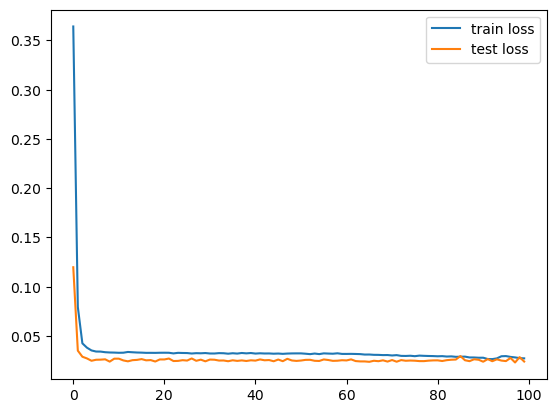

In [23]:
plt.plot(r.history['loss'], label='train loss') 
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

### Make Predictions

In [24]:
Ptrain_m = model.predict(Xtrain_m) 
Ptest_m = model.predict(Xtest_m)

print(Ptrain_m.shape, Ptest_m.shape)
print("Raw predictions (first 3 samples, first 3 steps):")
print(Ptest_m[:3, :3])
print(f"Mean of predictions: {Ptest_m.mean()}")
print(f"Std of predictions: {Ptest_m.std()}")

# Before inverse transform
print("Before inverse transform:", Ptest_m[:2, :2])

# After inverse transform
Ptest_m_original = scaler_ym.inverse_transform(Ptest_m)
print("After inverse transform:", Ptest_m_original[:2, :2]) 

Ptrain_m = scaler_ym.inverse_transform(Ptrain_m) 
Ptest_m = scaler_ym.inverse_transform(Ptest_m) 

Ptrain_m = Ptrain_m[:,0] 
Ptest_m = Ptest_m[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
(100, 12) (1, 12)
Raw predictions (first 3 samples, first 3 steps):
[[0.3878489  0.48167312 0.50095844]]
Mean of predictions: 0.44550642371177673
Std of predictions: 0.043936289846897125
Before inverse transform: [[0.3878489  0.48167312]]
After inverse transform: [[-0.02501149  0.01774663]]


### Multi-output forecast

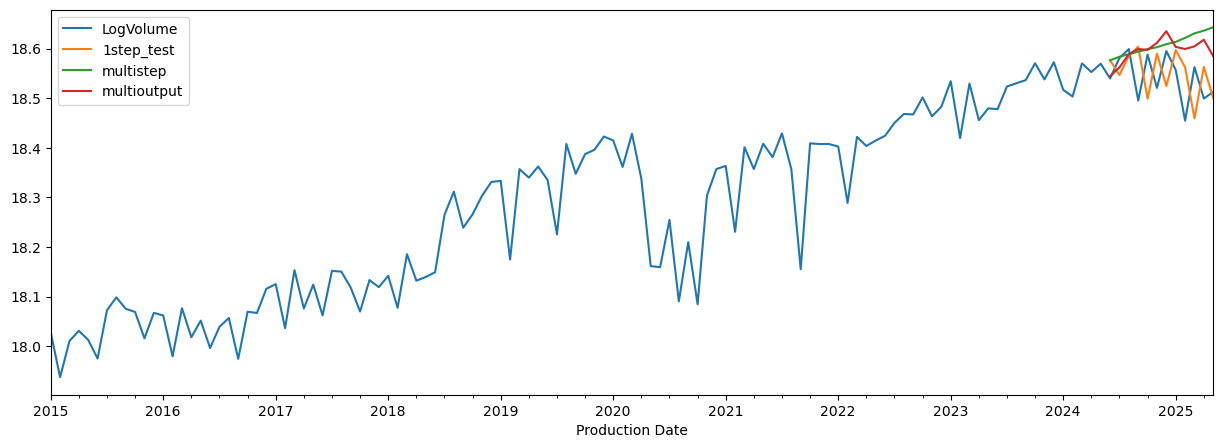

In [25]:
# multi-output forecast 
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest_m) 

cols = ['LogVolume','1step_test',  'multistep', 'multioutput'] 
df[cols].plot(figsize=(15,5));

### MAPE

In [26]:
test_log_pass = df.iloc[-Ntest:]['LogVolume'] 
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print('multi-step MAPE:', mape1) 
mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print('multi-output MAPE:', mape2) 
#mape3 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput2'])
#print('multi-output(2 LSTMs) MAPE:', mape3)

multi-step MAPE: 0.0036650922457154376
multi-output MAPE: 0.0031583785215525853
